In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime



Exploration Base de donnée

In [2]:
# Connexion (fichier ou mémoire)
con = duckdb.connect("football.duckdb")
# con = duckdb.connect()  # en mémoire

# Requête SQL
tables = con.execute("DESCRIBE tracking;").fetchall()
print(tables)

df = con.execute("""
    SELECT *
    FROM tracking
    WHERE (player_id, time_utc) IN (
        SELECT player_id, MIN(time_utc)
        FROM tracking
        GROUP BY player_id
    )
""").df()

print(df)

[('session_type', 'VARCHAR', 'YES', None, None, None), ('session_date', 'DATE', 'YES', None, None, None), ('player_id', 'INTEGER', 'YES', None, None, None), ('time_utc', 'TIMESTAMP', 'YES', None, None, None), ('x_pos', 'DOUBLE', 'YES', None, None, None), ('y_pos', 'DOUBLE', 'YES', None, None, None), ('latitude', 'DOUBLE', 'YES', None, None, None), ('longitude', 'DOUBLE', 'YES', None, None, None), ('speed_kmh', 'DOUBLE', 'YES', None, None, None), ('heart_rate', 'DOUBLE', 'YES', None, None, None), ('num_sat_fix', 'INTEGER', 'YES', None, None, None), ('hdop', 'DOUBLE', 'YES', None, None, None)]
   session_type session_date  player_id            time_utc      x_pos  \
0      practice   2019-07-04         21 2019-07-04 08:52:15 -12.139701   
1      practice   2019-07-04         10 2019-07-04 08:52:15  -8.582158   
2      practice   2019-07-04          5 2019-07-04 08:52:15 -16.108080   
3      practice   2019-07-04         13 2019-07-04 08:52:15 -13.842459   
4      practice   2019-07-04   

Mise en corrélation player_id (capteur_id) avec nom des joueurs csv. Afin de nettoyer les données pour ne pas obtenir les performances d'un autre joueurs.


In [10]:
#Lecture fichier CSV
df_csv = pd.read_csv("data/summary.csv", sep=",")
print(df_csv.columns)

#Afficher seulement les colonnes Sensor et last_name
print(df_csv[['Sensor', 'last_name', 'date']])

#Créer dataframe avec Sensor, last_name et date
df_filtered = df_csv[['Sensor', 'last_name', 'date']]
print(df_filtered.head())
#Print nombre de lignes et colonnes
print(df_filtered.shape)


Index(['Unnamed: 0', 'Sensor', 'last_name', 'first_name', 'date', 'type',
       'position', 'feature_distance', 'feature_d_speed_0_5',
       'feature_d_speed_5_10', 'feature_d_speed_10_15',
       'feature_d_speed_15_21', 'feature_d_speed_21_24',
       'feature_d_speed_24_30', 'feature_d_speed_over30', 'feature_hid_d_15',
       'feature_hid_d_21', 'feature_acc_3mss', 'feature_dec_3mss',
       'feature_acc_3.5mss', 'feature_dec_3.5mss', 'feature_acc_4mss',
       'feature_dec_4mss', 'feature_sprint_over24', 'feature_avg_speed',
       'feature_max_speed', 'feature_max_acc'],
      dtype='object')
      Sensor    last_name                 date
0          4     KNEZEVIC  2020-02-01 18:00:06
1          5        ALVES  2020-02-01 18:00:06
2          9    MARGIOTTA  2020-02-01 18:00:06
3         10        ELEKE  2020-02-01 18:00:06
4         11      SCHURPF  2020-02-01 18:00:06
...      ...          ...                  ...
4057      18        EMINI  2019-10-31 09:23:12
4058      20    

Création d'un dataframe qui ne contient que les 3 capteurs sur lequels je vais faire mon exploration.

In [11]:
#Compter le nombre de fois que le joueur last_name apparait avec le capteur Sensor
player_sensor_counts = df_filtered.groupby(['Sensor', 'last_name']).size().reset_index(name='counts')


#Trier  par counts décroissant
player_sensor_counts = player_sensor_counts.sort_values(by='counts', ascending=False)
print(player_sensor_counts)


#Lister last_name uniques
unique_players = df_filtered['last_name'].unique()
#Trier par ordre alphabétique
unique_players = sorted(unique_players)
print(unique_players)


    Sensor    last_name  counts
8        5        ALVES     225
7        4     KNEZEVIC     222
22      12       SIDLER     208
13       7        IBRAH     205
21      11      SCHURPF     187
15       9    MARGIOTTA     185
26      15       SCHULZ     178
29      17      GRETHER     161
25      14         VOCA     160
23      13       NDENGE     150
17      10        ELEKE     145
31      18        EMINI     144
37      20     DEMHASAJ     138
43      23  MISTVAFOVIC     128
41      21        MALES     125
52      77        RYDER     121
4        2    KAKABADZE     101
6        3     CIRKOVIC      97
5        3        BÜRKI      95
50      28          TIA      94
42      22        BURCH      94
47      27    SCHWEGLER      84
51      77            F      69
0        0    BALATUBAN      60
40      21         LINO      57
36      20      ALOUNGA      53
16       9       SORGIC      49
49      28      MARLEKU      47
9        6       ARNOLD      46
44      23        TAZAR      44
10      

Afin de simplifier l'exploration nous allons prendre 3 joueurs avec le plus de données et qui n'ont pas prêter leurs capteur. player_id 4,5,12 respectivement knezevic, alves, sidler.

In [12]:
#Afficher base de données duckdb
tables = con.execute("SHOW TABLES;").fetchall()
print(tables)

#Créer dataframe avec les données du joueur 4,5 et 12
player_data = con.execute("SELECT * FROM tracking WHERE player_id IN (4, 5, 12);").fetchdf()
print(player_data)

[('mapping_v',), ('sessions_aberrantes',), ('tracking',), ('tracking_acc',), ('tracking_acc_clean',), ('tracking_clean',), ('tracking_clean_speed',), ('tracking_clean_speed_filtered',), ('tracking_speed',), ('tracking_speed2',), ('tracking_v1',), ('tracking_v2',), ('tracking_v3',), ('tracking_v4',)]


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

         session_type session_date  player_id                time_utc  \
0                game   2020-01-11          4 2020-01-11 14:07:58.000   
1                game   2020-01-11          4 2020-01-11 14:07:58.100   
2                game   2020-01-11          4 2020-01-11 14:07:58.200   
3                game   2020-01-11          4 2020-01-11 14:07:58.300   
4                game   2020-01-11          4 2020-01-11 14:07:58.400   
...               ...          ...        ...                     ...   
28482422     practice   2019-09-13         12 2019-09-13 09:11:34.700   
28482423     practice   2019-09-13         12 2019-09-13 09:11:34.800   
28482424     practice   2019-09-13         12 2019-09-13 09:11:34.900   
28482425     practice   2019-09-13         12 2019-09-13 09:11:35.000   
28482426     practice   2019-09-13         12 2019-09-13 09:11:35.100   

               x_pos      y_pos   latitude  longitude  speed_kmh  heart_rate  \
0          32.487282  36.664406  36.500509 

   player_id  speed_kmh
2         12   33.43500
1          5   32.84712
0          4   30.75948
         player_id                time_utc  speed_kmh
7324876         12 2019-07-20 17:03:36.900   33.43500
9862233         12 2019-10-20 14:35:26.400   33.39072
7324875         12 2019-07-20 17:03:36.800   33.38568
9862232         12 2019-10-20 14:35:26.300   33.35976
9862231         12 2019-10-20 14:35:26.200   33.29532
7324877         12 2019-07-20 17:03:37.000   33.26256
7324874         12 2019-07-20 17:03:36.700   33.24168
7324871         12 2019-07-20 17:03:36.400   33.20280
9862234         12 2019-10-20 14:35:26.500   33.19704
7324873         12 2019-07-20 17:03:36.600   33.17436
  session_date  player_id  speed_kmh
0   2019-07-09          5   25.61148
1   2019-07-09         12   28.87344
2   2019-07-12          5   25.74180
3   2019-07-12         12   29.50380
4   2019-07-20          4   20.11284


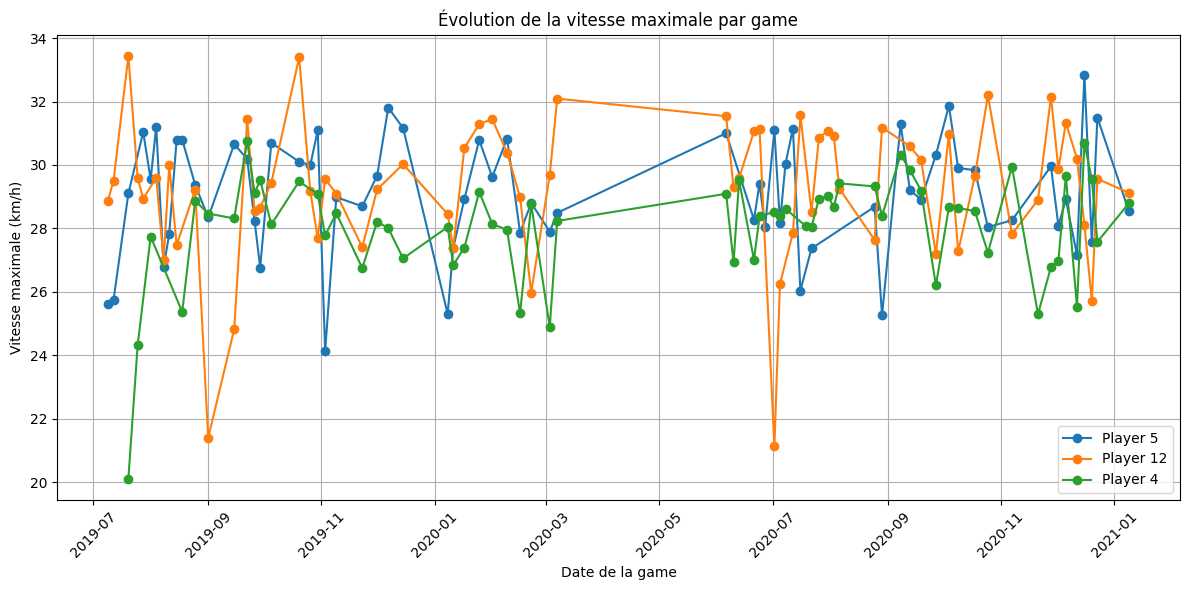

In [13]:
# Filtrer uniquement les sessions practice
game_data = player_data[player_data['session_type'] == 'game']
# Calcul de la vitesse max par joueur (en km/h)
#Afficher 10 maximum speed_kmh
max_speed = game_data.groupby('player_id')['speed_kmh'].max().reset_index()
print(max_speed.nlargest(10, 'speed_kmh'))
# Affichage de la distribution des vitesses maximales

top10_speeds = (
    game_data
    .nlargest(10, 'speed_kmh')
    [['player_id', 'time_utc', 'speed_kmh']]
)

print(top10_speeds)


#Afficher pour chaque game la vitesse maximale atteinte par chaque joueur
max_speed_per_game = (
    game_data
    .groupby(['session_date', 'player_id'])['speed_kmh']
    .max()
    .reset_index()
)

print(max_speed_per_game.head())
#Graphique

plt.figure(figsize=(12, 6))

for player_id in max_speed_per_game['player_id'].unique():
    player_df = max_speed_per_game[max_speed_per_game['player_id'] == player_id]
    
    # Important : trier par date
    player_df = player_df.sort_values('session_date')
    
    plt.plot(
        player_df['session_date'],
        player_df['speed_kmh'],
        marker='o',
        label=f'Player {player_id}'
    )

plt.title('Évolution de la vitesse maximale par game')
plt.xlabel('Date de la game')
plt.ylabel('Vitesse maximale (km/h)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




In [14]:
# Filtrer uniquement les sessions practice
practice_data = player_data[player_data['session_type'] == 'practice']

#Supprimer les lignes avec des valeurs supérieur à 50km/h
practice_data = practice_data[practice_data['speed_kmh'] > 0]
top10_speeds = (
    practice_data
    .nlargest(10, 'speed_kmh')
    [['player_id', 'time_utc', 'speed_kmh']]
)

print(top10_speeds)

max_speed_per_practice = (
    practice_data
    .groupby(['session_date', 'player_id'])['speed_kmh']
    .max()
    .reset_index()
)




          player_id                time_utc  speed_kmh
15099938         12 2020-01-24 15:24:10.100  166.08996
15099939         12 2020-01-24 15:24:10.200  165.09888
15099940         12 2020-01-24 15:24:10.300  163.68084
15099941         12 2020-01-24 15:24:10.400  162.05616
15099942         12 2020-01-24 15:24:10.500  160.74576
15099943         12 2020-01-24 15:24:10.600  159.45192
15099944         12 2020-01-24 15:24:10.700  158.15628
15099945         12 2020-01-24 15:24:10.800  156.81780
15099946         12 2020-01-24 15:24:10.900  155.45916
15099947         12 2020-01-24 15:24:11.000  154.07352


# Vitesse

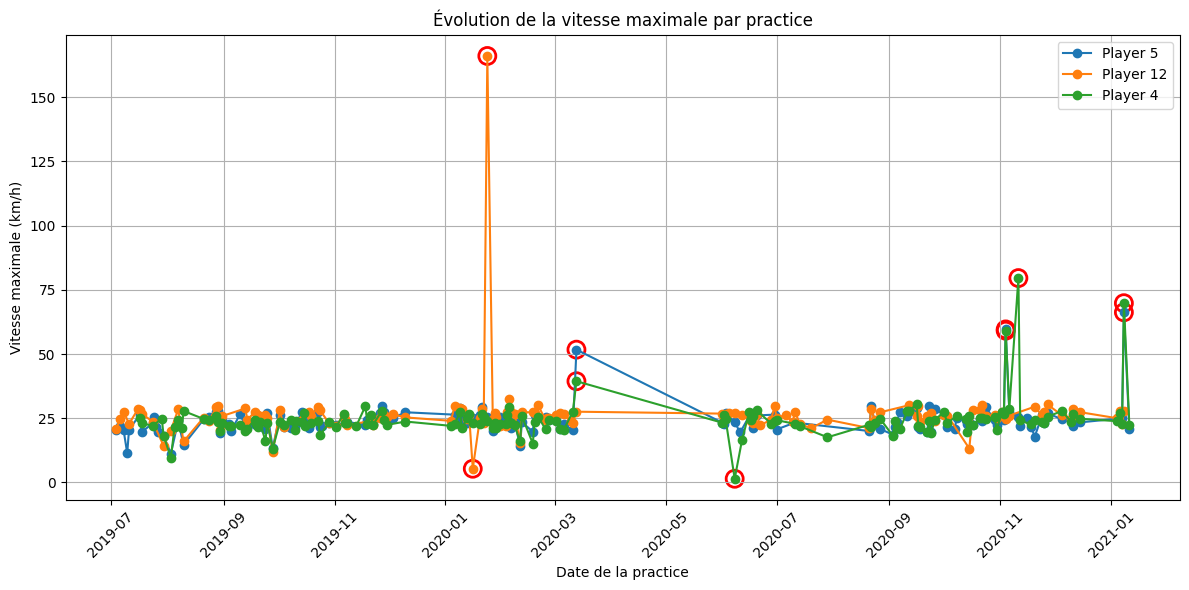

In [15]:
#Ajouter un cercle autour des points du graphique qui sont au dessus de 35 km/h

plt.figure(figsize=(12, 6))

SEUILmax = 35  # km/h
SEUILmin = 9  # km/h

for player_id in max_speed_per_practice['player_id'].unique():
    player_df = (
        max_speed_per_practice[
            max_speed_per_practice['player_id'] == player_id
        ]
        .sort_values('session_date')
    )
    
    # Courbe normale
    plt.plot(
        player_df['session_date'],
        player_df['speed_kmh'],
        marker='o',
        label=f'Player {player_id}'
    )
    
    # Points au-dessus du seuil
    high_speed = player_df[player_df['speed_kmh'] > SEUILmax]
    low_speed = player_df[player_df['speed_kmh'] < SEUILmin]
    plt.scatter(
        low_speed['session_date'],
        low_speed['speed_kmh'],
        facecolors='none',   # cercle vide
        edgecolors='red',    # contour rouge
        s=150,               # taille du cercle
        linewidths=2
    )
    plt.scatter(
        high_speed['session_date'],
        high_speed['speed_kmh'],
        facecolors='none',   # cercle vide
        edgecolors='red',    # contour rouge
        s=150,               # taille du cercle
        linewidths=2
    )

plt.title('Évolution de la vitesse maximale par practice')
plt.xlabel('Date de la practice')
plt.ylabel('Vitesse maximale (km/h)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

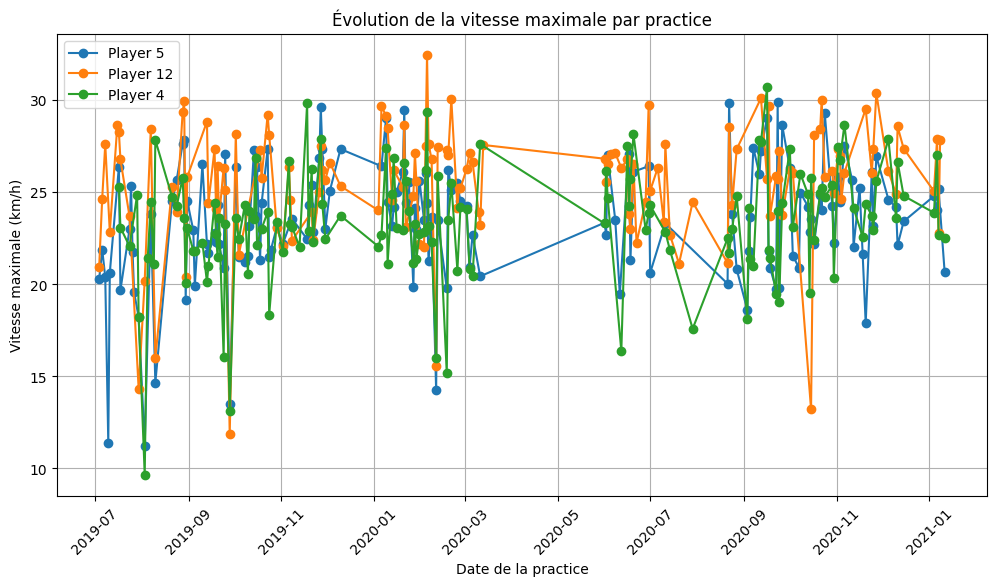

In [16]:
#SUPPRIMER session practice avec une vitesse max supérieur à 35 km/h et inférieur à 10 km/h
valid_practices = max_speed_per_practice[
    (max_speed_per_practice['speed_kmh'] <= SEUILmax) &
    (max_speed_per_practice['speed_kmh'] >= SEUILmin)
]

#Afficher graphique avec les données valides seulement
plt.figure(figsize=(12, 6))
for player_id in valid_practices['player_id'].unique():
    player_df = (
        valid_practices[
            valid_practices['player_id'] == player_id
        ]
        .sort_values('session_date')
    )
    
    # Courbe normale
    plt.plot(
        player_df['session_date'],
        player_df['speed_kmh'],
        marker='o',
        label=f'Player {player_id}'
    )
plt.title('Évolution de la vitesse maximale par practice')
plt.xlabel('Date de la practice')
plt.ylabel('Vitesse maximale (km/h)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Distance

In [17]:
player_data = player_data.sort_values(
    ['player_id', 'session_date', 'time_utc']
)
player_data['distance_step'] = np.sqrt(
    player_data.groupby(['player_id', 'session_date'])['x_pos'].diff()**2 +
    player_data.groupby(['player_id', 'session_date'])['y_pos'].diff()**2
)
player_data['distance_step'] = player_data['distance_step'].fillna(0)

player_data['distance_cum'] = (
    player_data
    .groupby(['player_id', 'session_date'])['distance_step']
    .cumsum()
)
print(
    player_data[
        ['player_id', 'session_date', 'time_utc', 'distance_step', 'distance_cum']
    ].head(10)
)

session_date = '2020-06-01'
player_id = 4

player_session_data = player_data[
    (player_data['session_date'] == session_date) &
    (player_data['player_id'] == player_id)
]

total_distance = player_session_data['distance_cum'].iloc[-1]

print(
    f"Distance totale parcourue par le joueur {player_id} "
    f"le {session_date} : {total_distance:.2f} m"
)

          player_id session_date                time_utc  distance_step  \
26400679          4   2019-07-17 2019-07-17 08:15:36.000       0.000000   
26400680          4   2019-07-17 2019-07-17 08:15:36.100       0.007602   
26400681          4   2019-07-17 2019-07-17 08:15:36.200       0.015203   
26400682          4   2019-07-17 2019-07-17 08:15:36.300       0.007601   
26400683          4   2019-07-17 2019-07-17 08:15:36.400       0.007602   
26400684          4   2019-07-17 2019-07-17 08:15:36.500       0.015203   
26400685          4   2019-07-17 2019-07-17 08:15:36.600       0.013469   
26400686          4   2019-07-17 2019-07-17 08:15:36.700       0.007602   
26400687          4   2019-07-17 2019-07-17 08:15:36.800       0.007601   
26400688          4   2019-07-17 2019-07-17 08:15:36.900       0.013468   

          distance_cum  
26400679      0.000000  
26400680      0.007602  
26400681      0.022805  
26400682      0.030406  
26400683      0.038008  
26400684      0.053211  

Les valeurs obtenus dans summarize sont bonne

     last_name                 date  feature_distance
1874  KNEZEVIC  2019-07-04 08:52:15              6.28
1875  KNEZEVIC  2019-07-06 08:13:47             10.08
1876  KNEZEVIC  2019-07-08 08:45:22              4.19
1877  KNEZEVIC  2019-07-09 17:59:09              7.81
1878  KNEZEVIC  2019-07-10 08:37:51              3.38
...        ...                  ...               ...
2097  KNEZEVIC  2021-01-06 08:54:56              6.56
2098  KNEZEVIC  2021-01-07 08:59:49              2.09
2099  KNEZEVIC  2021-01-08 08:55:19              6.93
2100  KNEZEVIC  2021-01-09 13:00:49              5.69
2101  KNEZEVIC  2021-01-11 08:59:56              5.71

[228 rows x 3 columns]


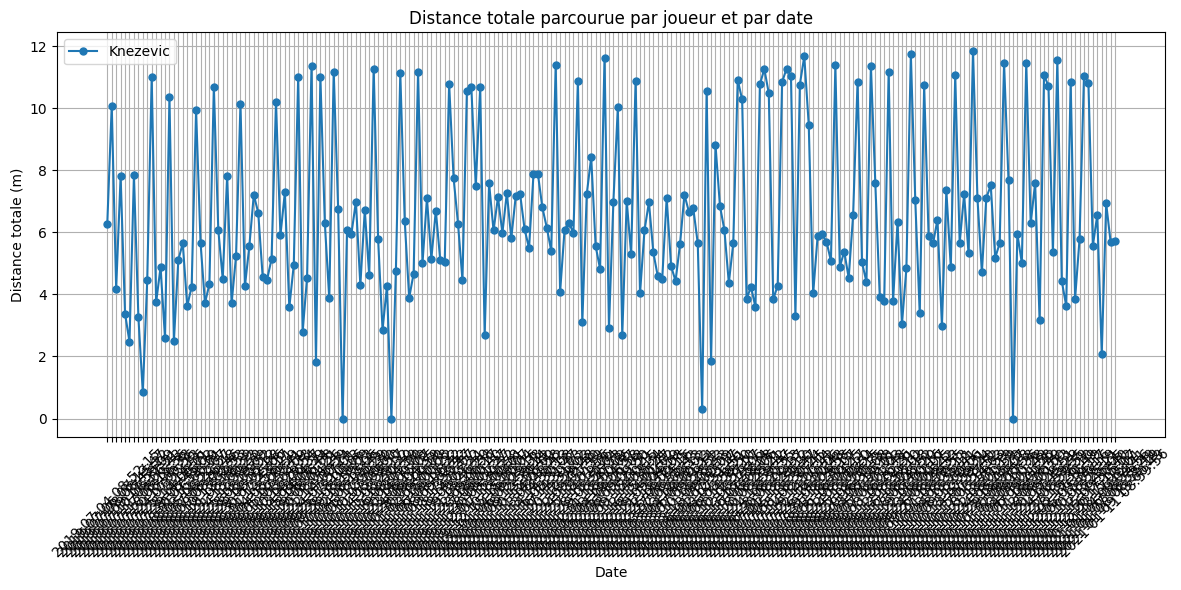

In [18]:
#Afficher distance totale pour chaque joueur et chaque session_date à partir de summary.csv
#colonne feature_distance 
distance_summary = df_csv.groupby(
    ['last_name', 'date']
)['feature_distance'].sum().reset_index()

#Créer dataframe avec seulment 3 joueurs : knezevic, alves, sidler
selected_players = ['knezevic']
distance_selected = distance_summary[
    distance_summary['last_name'].str.lower().isin(selected_players)
]
print(distance_selected)

#Graphique distance totale par joueur et par date
plt.figure(figsize=(12, 6))

for player in selected_players:
    player_data = distance_selected[distance_selected['last_name'].str.lower() == player]
    
    plt.plot(
        player_data['date'],
        player_data['feature_distance'],
        label=player.capitalize(),
        marker='o',  # ajouter des marqueurs pour les points
        markersize=5  # taille des points
    )

plt.xlabel('Date')
plt.ylabel('Distance totale (m)')
plt.title('Distance totale parcourue par joueur et par date')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
#Comparer distance totale est vitesse maximale pour chaque joueur et chaque session_date
#Créer dataframe de comparaison entre distance_summary et max_speed_per_practice
# Exemple : sélectionner les joueurs d'intérêt
selected_players = ['knezevic', 'alves', 'sidler']

#Print date pour valid_practices
print(valid_practices['session_date'].unique())

#Print date pour distance_selected
print(distance_selected['date'].unique())

<DatetimeArray>
['2019-07-04 00:00:00', '2019-07-06 00:00:00', '2019-07-08 00:00:00',
 '2019-07-10 00:00:00', '2019-07-11 00:00:00', '2019-07-16 00:00:00',
 '2019-07-17 00:00:00', '2019-07-18 00:00:00', '2019-07-24 00:00:00',
 '2019-07-25 00:00:00',
 ...
 '2020-11-27 00:00:00', '2020-12-05 00:00:00', '2020-12-10 00:00:00',
 '2020-12-11 00:00:00', '2020-12-15 00:00:00', '2021-01-04 00:00:00',
 '2021-01-06 00:00:00', '2021-01-07 00:00:00', '2021-01-08 00:00:00',
 '2021-01-11 00:00:00']
Length: 172, dtype: datetime64[us]
['2019-07-04 08:52:15' '2019-07-06 08:13:47' '2019-07-08 08:45:22'
 '2019-07-09 17:59:09' '2019-07-10 08:37:51' '2019-07-11 09:06:43'
 '2019-07-17 08:15:36' '2019-07-18 08:06:38' '2019-07-20 17:00:56'
 '2019-07-24 07:55:13' '2019-07-25 18:14:56' '2019-07-28 14:00:01'
 '2019-07-29 08:45:02' '2019-07-30 07:59:39' '2019-08-01 16:00:01'
 '2019-08-03 12:52:07' '2019-08-05 08:22:57' '2019-08-07 08:26:48'
 '2019-08-09 08:09:46' '2019-08-10 13:02:53' '2019-08-18 13:59:53'
 '2019-

Heat road map

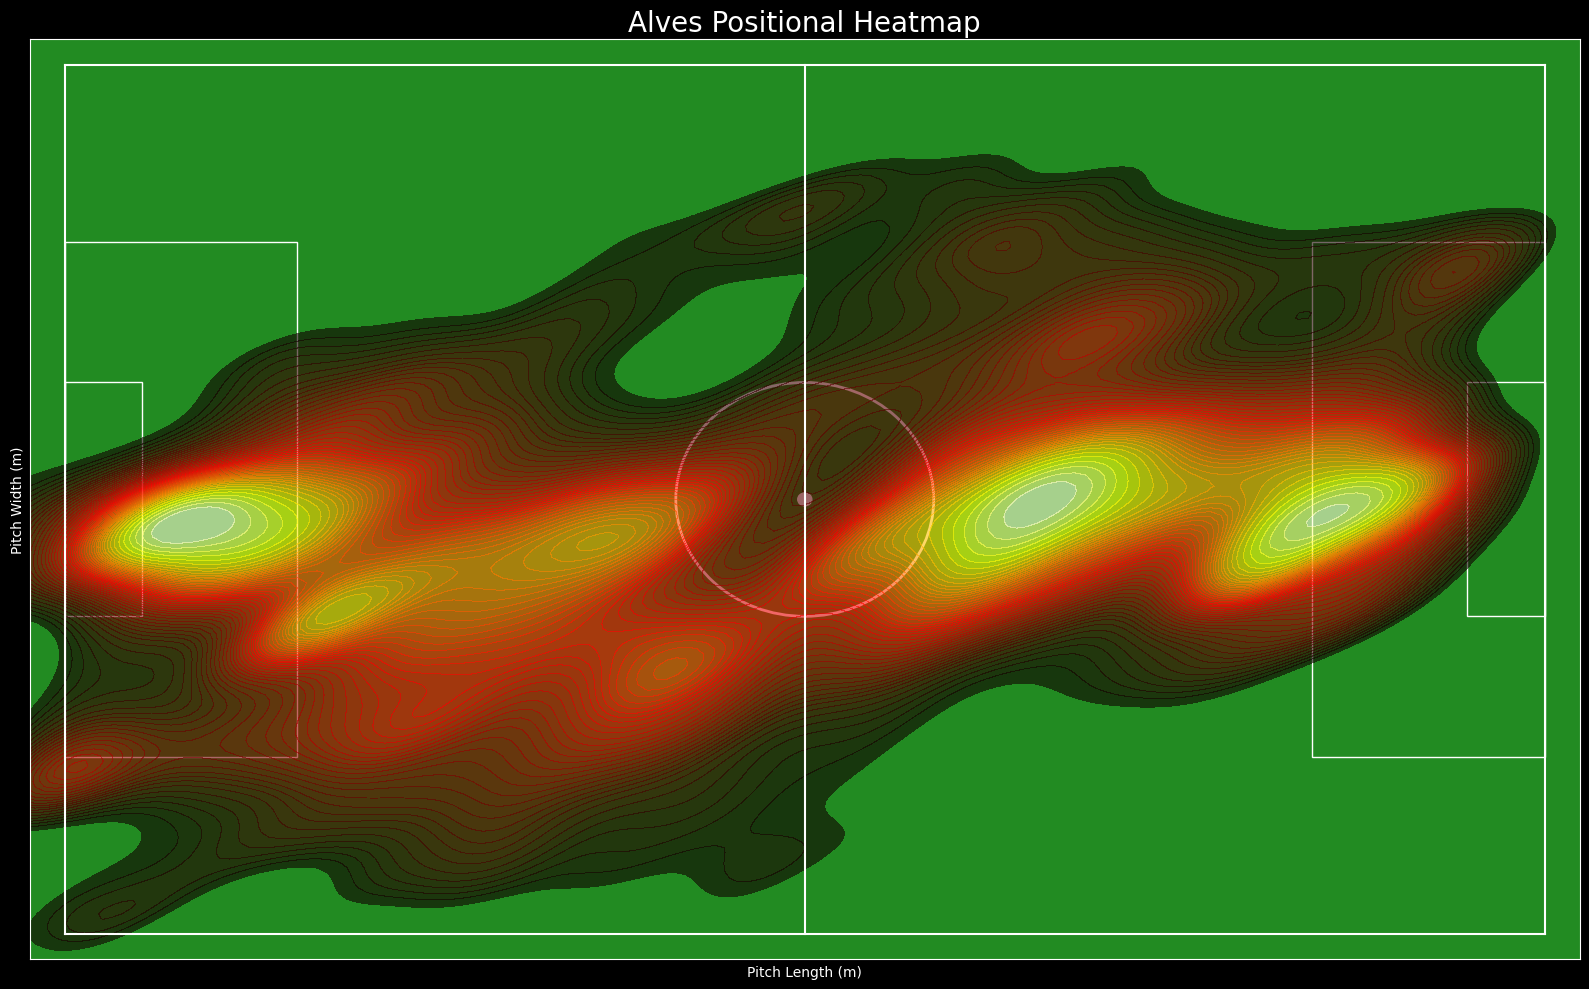

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc, Rectangle, Circle

players_df = con.execute("""
    SELECT
    x_pos - 55 AS x_smooth,
    y_pos - 36 AS y_smooth
    FROM tracking_clean
    WHERE session_type = 'game'
    AND session_date = '2020-02-01'
    AND player_name = 'ALVES'
""").df()


def draw_pitch(ax, pitch_color='#228B22', line_color='white'):
    """
    Draws a football pitch on a matplotlib axes object.
    """
    ax.set_facecolor(pitch_color)
    
    # Pitch Outline & Halfway Line
    ax.plot([0, 0], [-34, 34], color=line_color) # Halfway line
    ax.plot([-52.5, 52.5], [-34, -34], color=line_color) # Bottom line
    ax.plot([-52.5, 52.5], [34, 34], color=line_color)   # Top line
    ax.plot([-52.5, -52.5], [-34, 34], color=line_color) # Left line
    ax.plot([52.5, 52.5], [-34, 34], color=line_color)   # Right line
    
    # Center Circle
    center_circle = Circle((0.0, 0.0), 9.15, edgecolor=line_color, facecolor='none', lw=2)
    ax.add_patch(center_circle)
    center_dot = Circle((0.0, 0.0), 0.5, color=line_color)
    ax.add_patch(center_dot)
    
    # Penalty Areas
    ax.add_patch(Rectangle((-52.5, -20.15), 16.5, 40.3, edgecolor=line_color, facecolor='none'))
    ax.add_patch(Rectangle((36, -20.15), 16.5, 40.3, edgecolor=line_color, facecolor='none'))
    
    # 6-yard Box
    ax.add_patch(Rectangle((-52.5, -9.16), 5.5, 18.32, edgecolor=line_color, facecolor='none'))
    ax.add_patch(Rectangle((47, -9.16), 5.5, 18.32, edgecolor=line_color, facecolor='none'))

    return ax

# --- 1. Create the Plot ---
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(16, 10))
plt.style.use('dark_background')

# --- 2. Draw the Pitch ---
# Use the function to draw a pitch as the background
ax = draw_pitch(ax)

# --- 3. Generate and Overlay the Heatmap ---
# Using seaborn's Kernel Density Estimate (KDE) plot for a smooth heatmap.
sns.kdeplot(
    x=players_df['x_smooth'],
    y=players_df['y_smooth'],
    fill=True,
    cmap="hot",
    n_levels=50,
    alpha=0.6,  # Set transparency to see the pitch lines underneath
    ax=ax
)

# --- 4. Final Touches ---
ax.set_xlim(-55, 55)
ax.set_ylim(-36, 36)
ax.set_title('Alves Positional Heatmap', fontsize=20, color='white')
ax.set_xlabel('Pitch Length (m)', color='white')
ax.set_ylabel('Pitch Width (m)', color='white')

# Remove axis ticks for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

Profile accélération vitesse

In [ ]:
profile_df = con.execute("""
SELECT
    player_id,
    time_utc,
    speed_kmh / 3.6 AS speed_ms
FROM tracking_clean_step2
WHERE session_type = 'game'
AND session_date = '2020-02-01'
AND speed_kmh IS NOT NULL
ORDER BY player_id, time_utc;
""").df()


In [ ]:
profile2_df = con.execute("""
SELECT
    player_id,
    time_utc,
    speed_kmh / 3.6 AS speed_ms,
    (speed_kmh / 3.6 - 
     LAG(speed_kmh / 3.6) OVER (
         PARTITION BY player_id 
         ORDER BY time_utc
     )
    ) /
    EXTRACT(EPOCH FROM (
        time_utc - LAG(time_utc) OVER (
            PARTITION BY player_id 
            ORDER BY time_utc
        )
    )) AS acceleration_ms2
FROM tracking_clean_step2
WHERE session_type = 'game'
AND session_date = '2020-02-01';
""").df()

In [ ]:
profile3_df = con.execute("""
SELECT
    player_id,
    FLOOR(speed_ms) AS speed_bin,
    AVG(acceleration_ms2) AS mean_acc,
    COUNT(*) AS n_points
FROM profile2_df
WHERE acceleration_ms2 IS NOT NULL
GROUP BY player_id, speed_bin
ORDER BY speed_bin;
""").df()

In [ ]:

player_name = "KNEZEVIC"   
#Afficher vitesse et acceleration pour un joueur
player_profile = profile3_df[profile3_df['player_id'] == player_name]
vitesse = player_profile['speed_bin']
acceleration = player_profile['mean_acc']
print(vitesse)
print(acceleration)

